In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pykalman

sns.set_color_codes("colorblind")

## LDS model
Latent variables follow rotational dynamics A

In [2]:
# dimensions
n_dim_latents = 2
n_dim_obs = 10   # observed dimension = no of neurons
theta = np.deg2rad(14)  # angle of rotation in dynamics (in radiants for np.cos and np.sin)

# model parameters
params = {  
    'z0': np.ones(n_dim_latents), # initial state of latents
    'sigma0': 0.01 * np.eye(n_dim_latents),  # initial state noise covariance
    'A': np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]), # latent dynamics matrix
    # 'A': np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]]), # different dynamics matrix
    'V': 0.0001*np.eye(n_dim_latents), # latents noise covariance
    'B': 0.5 * np.hstack([np.random.uniform(size=(n_dim_obs,1)), -1*np.random.uniform(size=(n_dim_obs,1))]), # observation matrix
    'W': 0.001*np.eye(n_dim_obs), # observation covariance matrix
}


In [3]:
# dynamics matrix
params['A']

array([[ 0.97029573, -0.2419219 ],
       [ 0.2419219 ,  0.97029573]])

In [4]:
# observation matrix
params['B']

array([[ 0.03186084, -0.06161953],
       [ 0.05131382, -0.41340411],
       [ 0.22806174, -0.29541809],
       [ 0.07156368, -0.01381453],
       [ 0.2722872 , -0.15340905],
       [ 0.05142392, -0.17915426],
       [ 0.25004523, -0.39358319],
       [ 0.24110567, -0.36476627],
       [ 0.44993518, -0.3831165 ],
       [ 0.14086652, -0.42081321]])

### Gaussian data

In [5]:
def generate_gaussian_data(n_timesteps, params, seed=0):
    """
    Generate sequence of latent and observed variables from a linear dynamical system

    Args:
    n_timesteps (int): the number of time steps to simulate
    params (dict): a dictionary of model parameters (z0, sigma0, A, B, V, W)
    seed (int): a random seed for reproducibility checks

    Returns:
    ndarray, ndarray: sequence of generated latent and observed data
    """

    n_dim_latents = params['A'].shape[0]
    n_dim_obs = params['B'].shape[0]

    z_seq = np.zeros((n_timesteps, n_dim_latents))
    data = np.zeros((n_timesteps, n_dim_obs))

    #set seed
    np.random.seed(seed)

    # precompute random samples from the provided covariance matrices
    # mean defaults to 0
    ni = stats.multivariate_normal(cov=params['V']).rvs(n_timesteps)
    eta = stats.multivariate_normal(cov=params['W']).rvs(n_timesteps)

    for t in range(n_timesteps):
        # latent variables
        if t==0: 
            z_seq[t] = stats.multivariate_normal(mean=params['z0'], cov=params['sigma0']).rvs(1)
        else:
            z_seq[t] = params['A'] @ z_seq[t-1] + ni[t]
        # observed data
        data[t] = params['B'] @ z_seq[t] + eta[t]
            
    return z_seq, data

In [6]:
n_timesteps=10000
z_seq, obs_seq = generate_gaussian_data(n_timesteps, params)

Text(0, 0.5, 'neurons')

<Figure size 432x288 with 0 Axes>

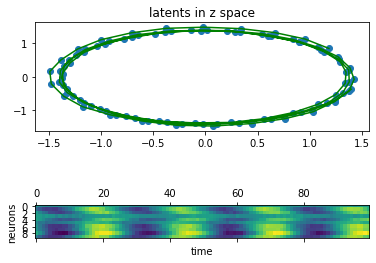

In [7]:
## Plots

end = 100 # end of sequence for partial plots

plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    BB
    DD
    """, 
    gridspec_kw=dict(hspace=1, wspace=1,
                     #width_ratios=[1,1],
                     height_ratios=[3,1]
                     )
)
# axes["A"].imshow(z_seq[:end].T)
# axes["A"].set_title('latents')
axes["B"].scatter(z_seq[:end,0], z_seq[:end,1])
axes["B"].plot(z_seq[:end,0], z_seq[:end,1], color='green')
axes["B"].set_title('latents in z space')
axes["D"].matshow(obs_seq[:end].T)
axes["D"].set_xlabel('time')
axes["D"].set_ylabel('neurons')
# axes["D"].set_title('neural activity')

[]

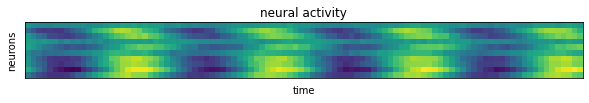

In [8]:
end = 100 # end of sequence for partial plots
fig,ax = plt.subplots(figsize=(10,4))
ax.matshow(obs_seq[:end].T)
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('neural activity')
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')

# fig.savefig('data.png')

[]

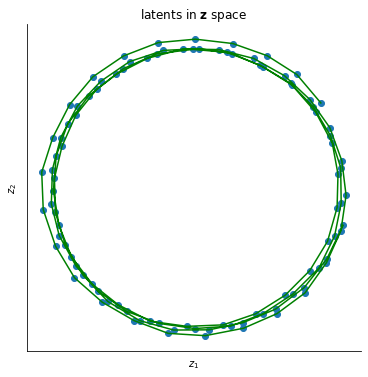

In [9]:
end=100
fig, ax = plt.subplots(figsize=[6,6])
ax.scatter(z_seq[:end,0], z_seq[:end,1])
ax.plot(z_seq[:end,0], z_seq[:end,1], color='green')
ax.set_title('latents in $\mathbf{z}$ space')
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')

# fig.savefig('latents.png')

### Kalman EM inference
With the Kalman filter we can infer the latents $Z$ from the observations $X$, so it finds $P(Z|X)$, where $$z_t = Az_{t-1} + \nu$$ $$x_t = Bz_t + \eta$$ with $\nu \sim \mathcal{N}(0,V)$ $\eta \sim \mathcal{N}(0,W)$ and $z_1 = \mu_0 + \sigma_0$, with $\sigma_0 \sim \mathcal{N}(0,\sigma_0)$

To infer the parameters of the dynamics as well $(A,B,V,W)$, we can implement the Expectation Maximisation algorithm via `pykalman`

In [10]:
# set up KalmanFilter object and the parameters to estimate with EM
kf = pykalman.KalmanFilter(
    n_dim_state=n_dim_latents,
    n_dim_obs=obs_seq.shape[1],    #observations=neurons in this instance
    em_vars=['transition_matrices', 'transition_covariance',
    'observation_matrices', 'observation_covariance']
)

# Provide initial states
kf.initial_state_mean = params['z0']
kf.initial_state_covariance = params['sigma0']

# Fit the spike data, note that input array has to be in the shape [n_timesteps, n_dim_obs]
kf.em(obs_seq)

print(f'D=\n{kf.transition_matrices}')
print(f'Q =\n{kf.transition_covariance}')
print(f'H =\n{kf.observation_matrices}')
# print(f'R =\n{kf.observation_covariance}')

D=
[[ 0.95698756  0.22813153]
 [-0.25367617  0.97216489]]
Q =
[[ 0.03059801 -0.0114142 ]
 [-0.0114142   0.01875065]]
H =
[[0.01638401 0.02977503]
 [0.02568517 0.20181974]
 [0.11823044 0.1425233 ]
 [0.0376117  0.00590265]
 [0.14119374 0.07246773]
 [0.02647258 0.0874748 ]
 [0.12953675 0.1904039 ]
 [0.12449561 0.17635085]
 [0.23359242 0.18298181]
 [0.07243051 0.2049754 ]]


In [11]:
print(f'A eigenvalues: {np.linalg.eig(params["A"])[0]}')
print(f'D eigenvalues: {np.linalg.eig(kf.transition_matrices)[0]}')

A eigenvalues: [0.97029573+0.2419219j 0.97029573-0.2419219j]
D eigenvalues: [0.96457622+0.2404453j 0.96457622-0.2404453j]


Text(0.5, 1.0, 'inferred latent dynamics')

<Figure size 432x288 with 0 Axes>

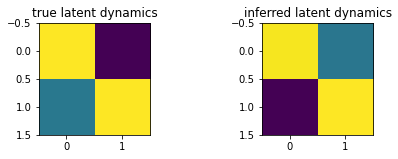

In [12]:
plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    AB
    """, 
    gridspec_kw=dict(hspace=1, wspace=1,
                     #width_ratios=[1,1],
                     #height_ratios=[5,10]
                     )
)
axes["A"].imshow(params['A'])
axes["A"].set_title('true latent dynamics')
# axes["A"].colorbar()
axes["B"].imshow(kf.transition_matrices)
axes["B"].set_title('inferred latent dynamics')
# axes["B"].colorbar()

In [13]:
# sample from the inferred dynamics
kf_latents, kf_spikes = kf.sample(len(obs_seq))

In [14]:
# Mean square error between true and inferred model
MSE_gauss = np.square(obs_seq-kf_spikes).mean()
MSE_gauss

0.16361593108749906

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

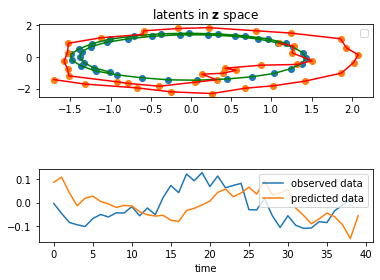

In [15]:
end = 40 # end of sequence for partial plots

plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    A
    B
    """, 
    gridspec_kw=dict(hspace=1, wspace=1,
                     width_ratios=[1],
                     height_ratios=[2,2])
)
axes["A"].scatter(z_seq[:end,0], z_seq[:end,1])
axes["A"].scatter(kf_latents[:end,0], kf_latents[:end,1])
axes["A"].plot(z_seq[:end,0], z_seq[:end,1], color='green')
axes["A"].plot(kf_latents[:end,0], kf_latents[:end,1], color='red')
axes["A"].set_title('latents in $\mathbf{z}$ space')
axes["A"].legend()
axes["B"].plot(obs_seq[:end,0], label='observed data')
axes["B"].plot(kf_spikes[:end,0], label='predicted data')
axes["B"].set_xlabel('time')
axes["B"].legend()
# axes["B"].set_title('latents in z space')
# axes["C"].plot(np.arange(end),np.exp(mean_spks[:end,0]))
# axes["C"].set_title('obs x')
# axes["C"].set_xlabel('time')
# axes["C"].set_ylabel('x')
# axes["D"].matshow(spike_counts[:end].T)
# axes["D"].set_xlabel('time')
# axes["D"].set_ylabel('neurons')
# axes["D"].set_title('spike counts')

[]

<Figure size 432x288 with 0 Axes>

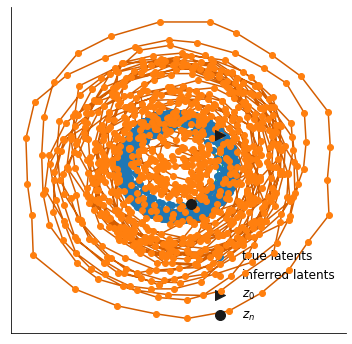

In [16]:
end=1000

plt.clf()
fig, ax = plt.subplots(figsize=[6,6])
ax.plot(z_seq[:end,0], z_seq[:end,1], color='g')
ax.plot(kf_latents[:end,0], kf_latents[:end,1], color='r')
ax.scatter(z_seq[:end,0], z_seq[:end,1], zorder=99, label='true latents')
ax.scatter(kf_latents[:end,0], kf_latents[:end,1], zorder=99, label='inferred latents')
ax.scatter(kf_latents[0,0], kf_latents[0,1], marker='>', c='k', ec='k', s=100, zorder=99, label='$z_0$')
ax.scatter(kf_latents[end,0], kf_latents[end,1], marker='o', c='k', ec='k', s=100, zorder=99, label='$z_n$')
ax.legend(fontsize=12, frameon=False)
# ax.set_title('latents in z space')
# ax.set_xlabel('$z_1$')
# ax.set_ylabel('$z_2$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')

# fig.savefig('latents_nofit.png')

Text(0, 0.5, 'neuron 1')

<Figure size 432x288 with 0 Axes>

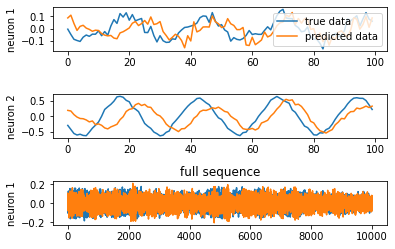

In [17]:
end = 100
plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    A
    B
    C
    """, 
    gridspec_kw=dict(hspace=1, wspace=1)
)
axes["A"].plot(obs_seq[:end,0], label='true data')
axes["A"].plot(kf_spikes[:end,0], label='predicted data')
axes["A"].set_ylabel('neuron 1')
axes["A"].legend()
axes["B"].plot(obs_seq[:end,1], label='true data')
axes["B"].plot(kf_spikes[:end,1], label='predicted data')
axes["B"].set_ylabel('neuron 2')
# axes["B"].legend()
axes["C"].plot(obs_seq[:,0], label='true data')
axes["C"].plot(kf_spikes[:,0], label='predicted data')
axes["C"].set_title('full sequence')
axes["C"].set_ylabel('neuron 1')
# axes["C"].legend()

Text(0.5, 0, 'time')

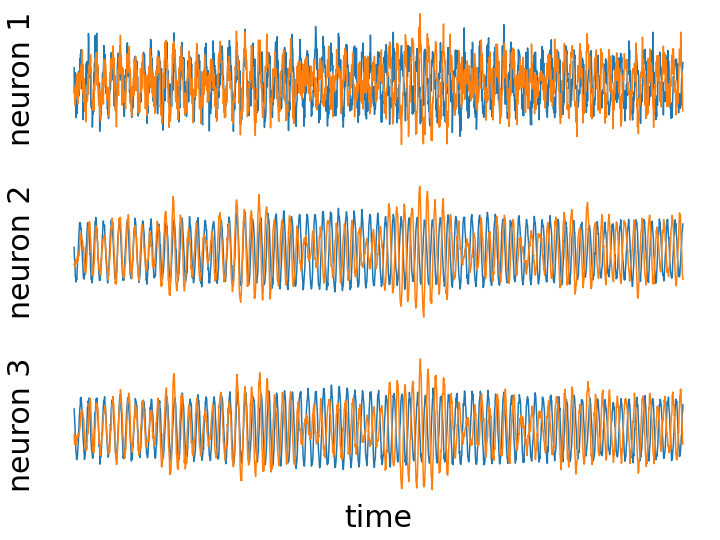

In [18]:
n_nrn = 3   #number of example neurons
startT = 1000
endT = 3000
fig,ax = plt.subplots(n_nrn,1,figsize=[12,n_nrn*3])
for j in range(n_nrn):
    ax[j].plot(obs_seq[startT:endT,j], label='true data')
    ax[j].plot(kf_spikes[startT:endT,j], label='predicted data')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].set_ylabel(f'neuron {j+1}', fontsize=30)
    ax[j].set_yticks([])
    ax[j].set_xticks([])
ax[n_nrn-1].tick_params(axis='x', labelsize=20)
ax[n_nrn-1].set_xlabel('time', fontsize=30)
# plt.legend(frameon=False)

# fig.savefig('data.png')

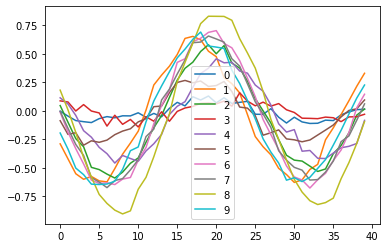

In [19]:
for k in range(len(obs_seq[0])):
    plt.plot(obs_seq[:40,k],label=str(k))
plt.legend()

## Poisson data

In [20]:
def generate_poisson_data(n_timesteps, params, seed=0):
    """
    Generate sequence of latent and observed variables from a linear dynamical system

    Args:
    n_timesteps (int): the number of time steps to simulate
    params (dict): a dictionary of model parameters (z0, A, B, S)
    seed (int): a random seed for reproducibility checks

    Returns:
    ndarray, ndarray, ndarray: sequence of generated latent, observed data and spikes
    """

    n_dim_latents = params['A'].shape[0]
    n_dim_obs = params['B'].shape[0]

    z_seq = np.zeros((n_timesteps, n_dim_latents))
    mean_spks = np.zeros((n_timesteps, n_dim_obs))  #auxiliary var to generate poisson spikes
    spikes = np.zeros((n_timesteps, n_dim_obs))

    #set seed
    np.random.seed(seed)
    ni = stats.multivariate_normal(cov=params['V']).rvs(n_timesteps)

    for t in range(n_timesteps):
        # latent variables
        if t==0: 
            z_seq[t] = stats.multivariate_normal(mean=params['z0'], cov=params['sigma0']).rvs(1)
        else:
            z_seq[t] = params['A'] @ z_seq[t-1] + ni[t]
        # observed data
        mean_spks[t] = params['B'] @ z_seq[t]
        for j in range(len(mean_spks[0])):
            spikes[t,j] = stats.poisson.rvs(np.exp(mean_spks[t,j]))
            
    return z_seq, spikes

In [21]:
z_seq, spike_counts = generate_poisson_data(n_timesteps, params)

Text(0.5, 1.0, 'spike counts')

<Figure size 432x288 with 0 Axes>

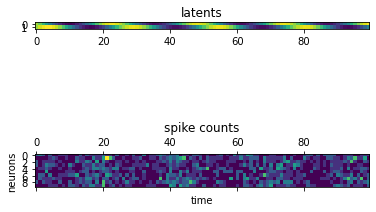

In [22]:
end = 100 # end of sequence for partial plots

plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    AA
    DD
    """, 
    gridspec_kw=dict(hspace=1, wspace=1,
                     #width_ratios=[1,1],
                     height_ratios=[5,10])
)
axes["A"].imshow(z_seq[:end].T)
axes["A"].set_title('latents')
# axes["B"].scatter(z_seq[:end,0], z_seq[:end,1])
# axes["B"].plot(z_seq[:end,0], z_seq[:end,1], color='green')
# axes["B"].set_title('latents in z space')
axes["D"].matshow(spike_counts[:end].T)
axes["D"].set_xlabel('time')
axes["D"].set_ylabel('neurons')
axes["D"].set_title('spike counts')

Text(0.5, 1.0, 'latents in z space')

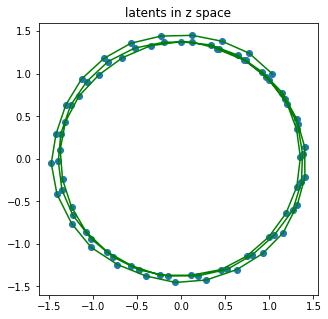

In [23]:
end=80
plt.figure(figsize=[5,5])
plt.scatter(z_seq[:end,0], z_seq[:end,1])
plt.plot(z_seq[:end,0], z_seq[:end,1], color='green')
plt.title('latents in z space')

In [24]:
# set up KalmanFilter object and the parameters to estimate with EM
kf = pykalman.KalmanFilter(
    n_dim_state=n_dim_latents,
    n_dim_obs=spike_counts.shape[1],    #observations=neurons in this instance
    em_vars=['transition_matrices', 'transition_covariance',
    'observation_matrices', 'observation_covariance']
)

# Provide initial states
kf.initial_state_mean = params['z0']
kf.initial_state_covariance = params['sigma0']

# Fit the spike data, note that input array has to be in the shape [n_timesteps, n_dim_obs]
kf.em(spike_counts)

print(f'D=\n{kf.transition_matrices}')
print(f'Q =\n{kf.transition_covariance}')
print(f'H =\n{kf.observation_matrices}')
# print(f'R =\n{kf.observation_covariance}')

D=
[[0.68050211 0.28928123]
 [0.27733327 0.71917394]]
Q =
[[ 0.33254751 -0.19022822]
 [-0.19022822  0.33551363]]
H =
[[0.58486189 0.10728757]
 [0.11519504 0.60065014]
 [0.34585462 0.38459968]
 [0.46039423 0.23734267]
 [0.38589094 0.32668679]
 [0.37465587 0.32029407]
 [0.31347949 0.42790608]
 [0.25686313 0.47649449]
 [0.27301714 0.50082631]
 [0.26877316 0.46623976]]


In [25]:
print(f'A eigenvalues: {np.linalg.eig(params["A"])[0]}')
print(f'D eigenvalues: {np.linalg.eig(kf.transition_matrices)[0]}')

A eigenvalues: [0.97029573+0.2419219j 0.97029573-0.2419219j]
D eigenvalues: [0.41593455 0.98374151]


Text(0.5, 1.0, 'estimated latent dynamics')

<Figure size 432x288 with 0 Axes>

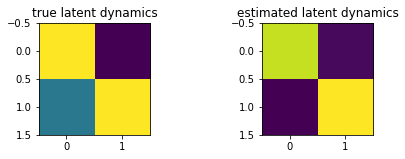

In [26]:
plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    AB
    """, 
    gridspec_kw=dict(hspace=1, wspace=1,
                     #width_ratios=[1,1],
                     #height_ratios=[5,10]
                     )
)
axes["A"].imshow(params['A'])
axes["A"].set_title('true latent dynamics')
# axes["A"].colorbar()
axes["B"].imshow(kf.transition_matrices)
axes["B"].set_title('estimated latent dynamics')
# axes["B"].colorbar()

In [27]:
# sample from the inferred dynamics
kf_latents, kf_spikes = kf.sample(len(spike_counts))

In [28]:
# mean squared error for poisson data
MSE_poiss = np.square(spike_counts-kf_spikes).mean()
MSE_poiss

4.679552275182434

<Figure size 432x288 with 0 Axes>

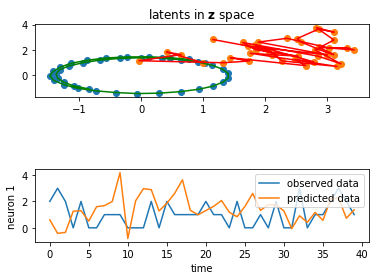

In [29]:
end = 40 # end of sequence for partial plots

plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    A
    B
    """, 
    gridspec_kw=dict(hspace=1, wspace=1,
                     width_ratios=[1],
                     height_ratios=[2,2])
)
axes["A"].scatter(z_seq[:end,0], z_seq[:end,1])
axes["A"].scatter(kf_latents[:end,0], kf_latents[:end,1])
axes["A"].plot(z_seq[:end,0], z_seq[:end,1], color='green')
axes["A"].plot(kf_latents[:end,0], kf_latents[:end,1], color='red')
axes["A"].set_title('latents in $\mathbf{z}$ space')
axes["B"].plot(spike_counts[:end,0], label='observed data')
axes["B"].plot(kf_spikes[:end,0], label='predicted data')
axes["B"].set_ylabel('neuron 1')
axes["B"].set_xlabel('time')
axes["B"].legend()
# axes["B"].set_title('latents in z space')
# axes["C"].plot(np.arange(end),np.exp(mean_spks[:end,0]))
# axes["C"].set_title('obs x')
# axes["C"].set_xlabel('time')
# axes["C"].set_ylabel('x')
# axes["D"].matshow(spike_counts[:end].T)
# axes["D"].set_xlabel('time')
# axes["D"].set_ylabel('neurons')
# axes["D"].set_title('spike counts')

[]

<Figure size 432x288 with 0 Axes>

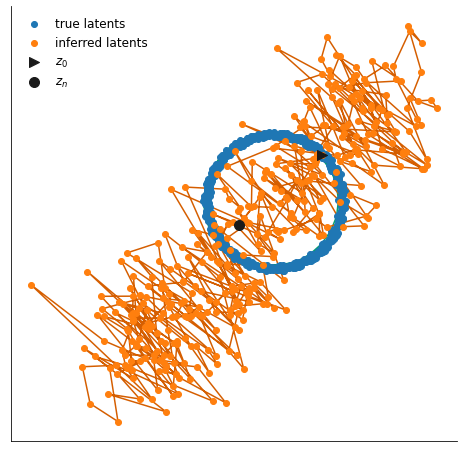

In [30]:
end=400
plt.clf()
fig, ax = plt.subplots(figsize=[8,8])
ax.plot(z_seq[:end,0], z_seq[:end,1], color='g')
ax.plot(kf_latents[:end,0], kf_latents[:end,1], color='r')
ax.scatter(z_seq[:end,0], z_seq[:end,1], zorder=99, label='true latents')
ax.scatter(kf_latents[:end,0], kf_latents[:end,1], zorder=99, label='inferred latents')
ax.scatter(kf_latents[0,0], kf_latents[0,1], marker='>', c='k', ec='k', s=100, zorder=99, label='$z_0$')
ax.scatter(kf_latents[end,0], kf_latents[end,1], marker='o', c='k', ec='k', s=100, zorder=99, label='$z_n$')
ax.legend(fontsize=12, frameon=False)
# ax.set_title('latents in z space')
# ax.set_xlabel('$z_1$')
# ax.set_ylabel('$z_2$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# ax.axis('off')

# fig.savefig('poiss_latents_fit.png')

Text(0.5, 1.0, 'full sequence')

<Figure size 432x288 with 0 Axes>

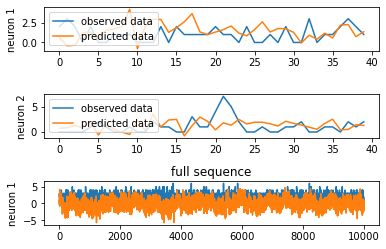

In [31]:
end = 40
plt.clf()
fig, axes = plt.subplot_mosaic(
    """
    A
    B
    C
    """, 
    gridspec_kw=dict(hspace=1, wspace=1)
)
axes["A"].plot(spike_counts[:end,0], label='observed data')
axes["A"].plot(kf_spikes[:end,0], label='predicted data')
axes["A"].set_ylabel('neuron 1')
axes["A"].legend()
axes["B"].plot(spike_counts[:end,1], label='observed data')
axes["B"].plot(kf_spikes[:end,1], label='predicted data')
axes["B"].set_ylabel('neuron 2')
axes["B"].legend()
axes["C"].plot(spike_counts[:,0], label='observed data')
axes["C"].plot(kf_spikes[:,0], label='predicted data')
axes["C"].set_ylabel('neuron 1')
axes["C"].set_title('full sequence')
# axes["C"].legend()

Text(0.5, 0, 'time')

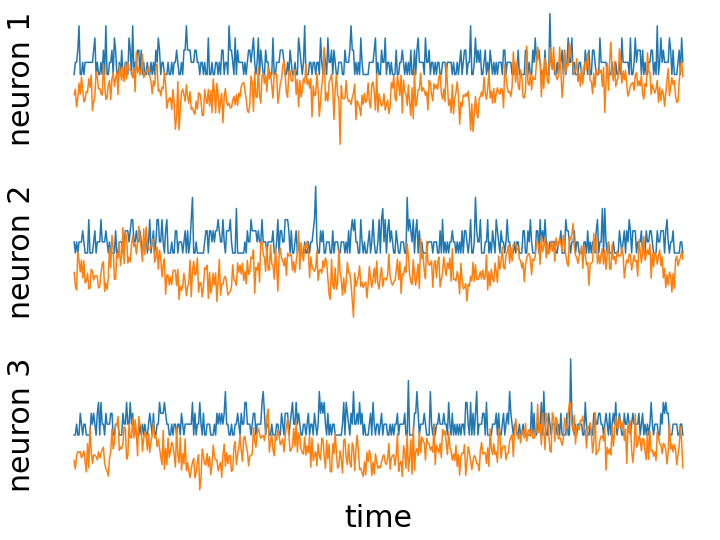

In [32]:
n_nrn=3 # number of example neurons to plot
startT = 1000
endT = 1500
fig,ax = plt.subplots(n_nrn,1,figsize=[12,n_nrn*3])
for j in range(n_nrn):
    ax[j].plot(spike_counts[startT:endT,j], label='true data')
    ax[j].plot(kf_spikes[startT:endT,j], label='predicted data')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].set_ylabel(f'neuron {j+1}', fontsize=30)
    ax[j].set_yticks([])
    ax[j].set_xticks([])
ax[n_nrn-1].tick_params(axis='x', labelsize=20)
ax[n_nrn-1].set_xlabel('time', fontsize=30)
# plt.legend(frameon=False)

# fig.savefig('poiss_data.png')

### Next steps

- consider longer time sequences to improve fit
- use EM algorithm on $\{B,V,W\}$ while fixing $A=\mathrm{I}$ to see whether the inferred noise can drive the latent dynamics in a circle